## Read in the rle segmentations file and convert all ship containing records to images.  

In [2]:
import os
import time
from collections import OrderedDict
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
from skimage.segmentation import find_boundaries
from skimage.morphology import label
from skimage.util import montage
from keras.preprocessing.image import save_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import quick_stats
from utils import multi_rle_encode
from utils import rle_decode
from utils import rle_to_border_mask
from utils import rle_to_stacked_mask
from utils import read_stacked_masks
from utils import read_flat_mask

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i], padding_width=10, fill=[1, 1, 1]) for i in range(x.shape[3])], -1)
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')
# import gc; gc.enable() # if memory is tight


/home/maddoxw/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/maddoxw/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
df = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations.csv'))
print(df.shape[0], 'masks found')
print(df['ImageId'].value_counts().shape[0])

131030 masks found
104070


### There is one bad file in the dataset so we need to remove it before we go any further.

In [4]:
# corrupted_train_ids = pd.read_csv(os.path.join(ship_dir, 'corruptedtrainimages.csv'))
# print(corrupted_train_ids.shape[0], 'corrupted train images found')
# print(corrupted_train_ids['ImageId'].value_counts().shape[0])
# corrupted_ids = corrupted_train_ids.drop_duplicates('ImageId')
# print(corrupted_train_ids.shape[0], corrupted_ids.shape[0])
# df.head()

print('6384c3e78.jpg' in df.values)
df = df.set_index("ImageId")
# for cid in corrupted_ids.values:
#     df = df.drop(cid, axis=0)
df = df.drop('6384c3e78.jpg', axis=0)
df = df.reset_index()

print(df.shape[0], 'masks found')
print(df['ImageId'].value_counts().shape[0])
print('6384c3e78.jpg' in df.values)
df.head()

True
131029 masks found
104069
False


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [5]:
unique_img_ids = df.groupby('ImageId').size().reset_index(name='counts')
print(unique_img_ids.shape[0])
print(unique_img_ids['ImageId'].value_counts().shape[0])
unique_img_ids.head()

104069
104069


,ImageId,counts
0,00003e153.jpg,1
1,000155de5.jpg,1
2,00021ddc3.jpg,9
3,0002756f7.jpg,2
4,0002d0f32.jpg,1


In [6]:
train_df = pd.merge(df, unique_img_ids)
print(train_df.shape[0])
train_df.head()

131029


,ImageId,EncodedPixels,counts
0,00003e153.jpg,NaN,1
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9


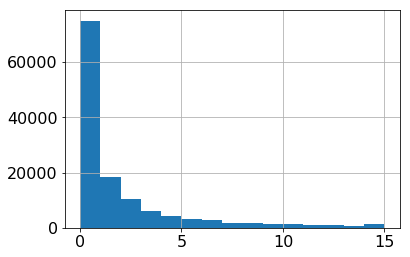

In [7]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
train_df['counts'].hist(bins=train_df['counts'].max());

### We can save a ton of space if we skip the images that don't have any ships.

In [8]:
train_df = train_df[train_df['counts'] >= 1]

In [9]:
print(train_df.shape[0])
print(train_df['ImageId'].value_counts().shape[0])
train_df.head()

56030
29070


,ImageId,EncodedPixels,counts
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9


In [9]:
all_batches = list(train_df.groupby('ImageId'))

# Save the inner mask (full mask - inner border) and thick border (inner border + outer border) as jpg

In [12]:
ImageId

'000fd9827.jpg'

          ImageId                                      EncodedPixels  counts
37  000fd9827.jpg  53262 2 54028 4 54794 7 55560 9 56326 12 57092...       1
(768, 768) bool True False 0.00026618109809027775 0.016312885879368386 157
(768, 768) bool True False 0.00014919704861111112 0.012213713147597517 88
(768, 768) bool True False 0.00019497341579861112 0.0139619268428732 115


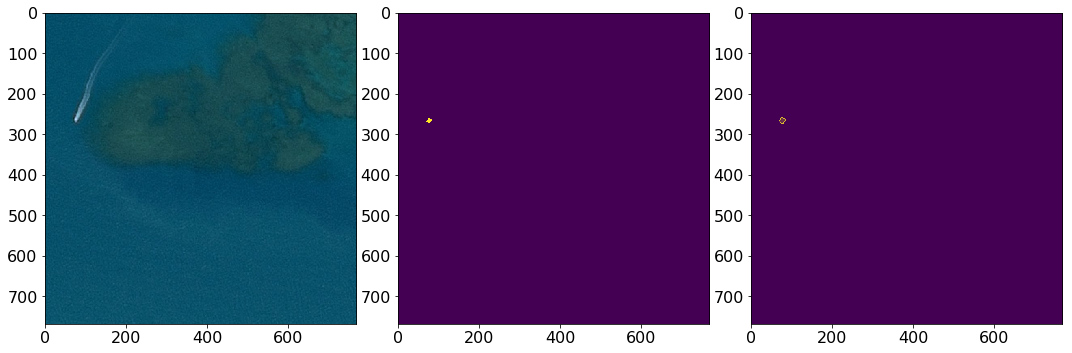

In [10]:
ImageId, c_masks = all_batches[9]
print(c_masks)
img = imread(os.path.join(train_image_dir, ImageId))
full_mask = rle_to_full_mask(c_masks['EncodedPixels'].values)

thick_border = rle_to_border_mask(c_masks['EncodedPixels'].values)

in_mask = full_mask & ~thick_border

# arr_mask = np.zeros((768, 768, 2), dtype=bool)
# arr_mask[..., 0] = in_mask
# arr_mask[..., 1] = thick_border

# img_mask = np.stack([full_mask, inner_mask, outer_mask], -1) * 255
# img_mask = np.array(arr_mask, dtype=np.uint8) * 255

quick_stats(full_mask)
quick_stats(thick_border)
quick_stats(in_mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(img)
axarr[1].imshow(in_mask)
axarr[2].imshow(thick_border)
axarr[2].imshow(in_mask, alpha=0.2)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [21]:
store.close()

In [28]:
with h5py.File('data/mask_1.h5', 'w') as mask_1, h5py.File('data/mask_1_thick_0.5.h5', 'w') as mask_2:
    mask_1.create_dataset(ImageId, data=full_mask)
    mask_2.create_dataset(ImageId, data=in_mask)

In [30]:
with h5py.File('data/mask_1.h5', 'r') as mask_1, h5py.File('data/mask_1_thick_0.5.h5', 'r') as mask_2:
    res = mask_1[ImageId][:]
    res2 = mask_2[ImageId][:]

In [33]:
t0 = time.time()
t1 = time.time()
# img_mask = np.zeros((768, 768, 3), dtype=np.uint8)
# arr_mask = np.zeros((768, 768, 1), dtype=bool)
# max_saves = 50
ii = 0
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
# with h5py.File('data/mask_1.h5', 'w') as mask_1, h5py.File('data/mask_1_thick_0.05.h5', 'w') as mask_2:
with h5py.File(os.path.append(ship_dir, 'mask_768.h5'), 'w') as mask_1:
    for ImageId, img_masks in all_batches:

        if ii % 5000 == 0:
            print(f'{ii} of {len(all_batches)}..., {(time.time() - t0) / 60} min')
            t1 = time.time()

        full_mask = rle_to_full_mask(img_masks['EncodedPixels'].values)
#         in_mask = full_mask & ~thick_border
#         in_mask_thick_border = in_mask[..., None] * 1.0 + thick_border[..., None] * 0.5

#         save_img(os.path.join('data/mask_1', ImageId), full_mask)
#         save_img(os.path.join('data/mask_1_thick_0.5', ImageId), in_mask_thick_border)
        mask_1.create_dataset(ImageId, data=full_mask)
#         mask_2.create_dataset(ImageId, data=in_mask_thick_border)
        
#     img_mask = np.array(arr_mask, dtype=np.uint8) * 255
#     arr_mask[..., 0] = in_mask
#     arr_mask[..., 1] = thick_border
#     img_mask = np.stack([full_mask, inner_mask, outer_mask], -1) * 255
#     save_img(os.path.join('data', ImageId), img_mask)
#     np.save(os.path.join('data', ImageId.replace('jpg', 'npy')), arr_mask)

        ii += 1
#     if ii > max_saves:
#         break
    
print((time.time() - t0) / 60)
print('complete')

0 of 29070..., 2.1445751190185548e-05 min
5000 of 29070..., 0.2545673608779907 min
10000 of 29070..., 0.49615200360616046 min
15000 of 29070..., 0.7387796918551127 min
20000 of 29070..., 0.9700566252072652 min
25000 of 29070..., 1.19666907787323 min
1.4488228917121888
complete
